In [1]:
"""
Notebook Matrix Profile – ampiimts Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with a fix window on matrix profile methode (stumpy)
"""
# %matplotlib widget
import pandas
from ampiimts import ampiimts
import os

Window size : 0 days 06:00:00 ---


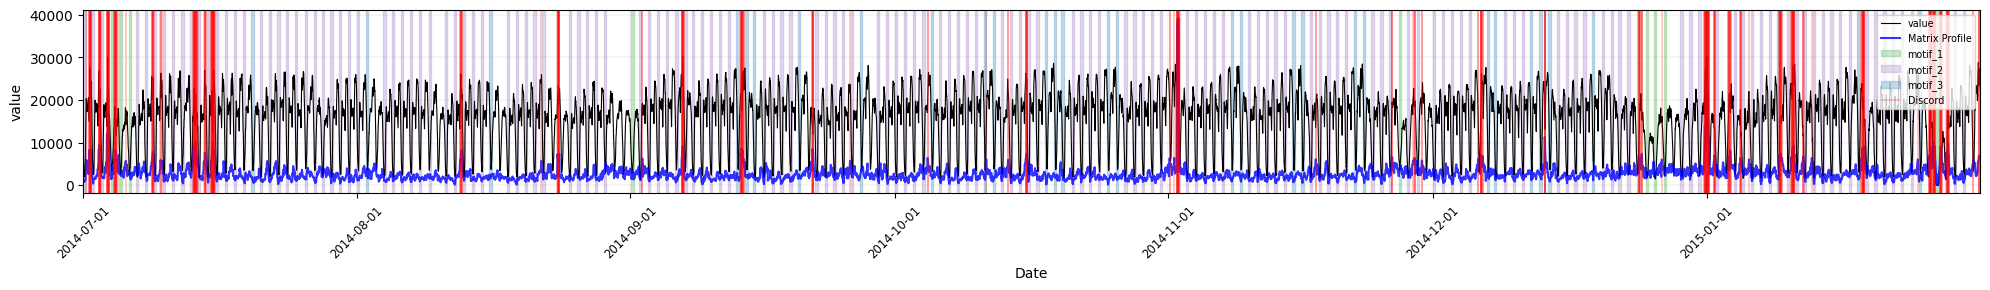

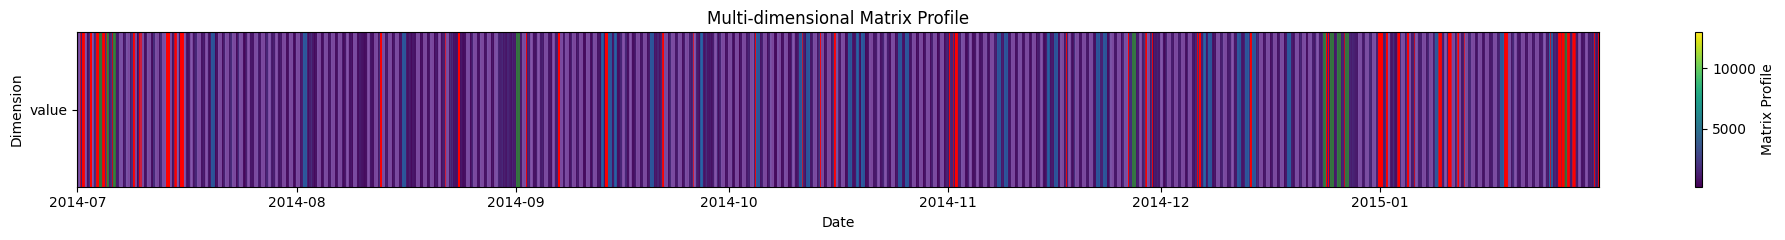

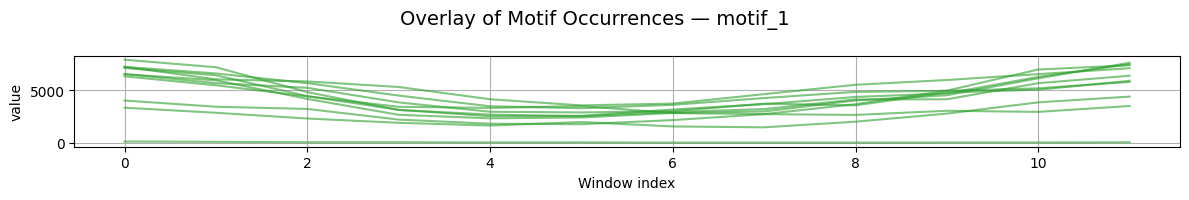

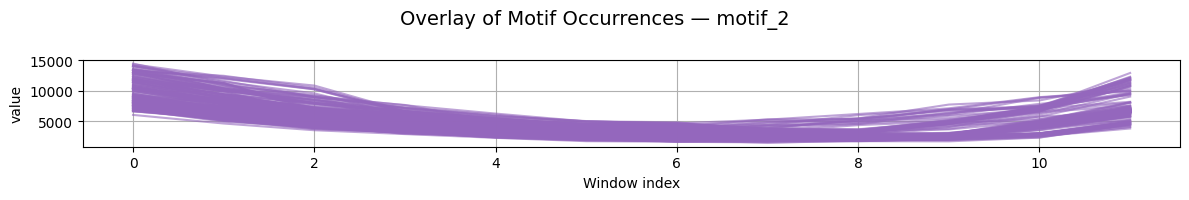

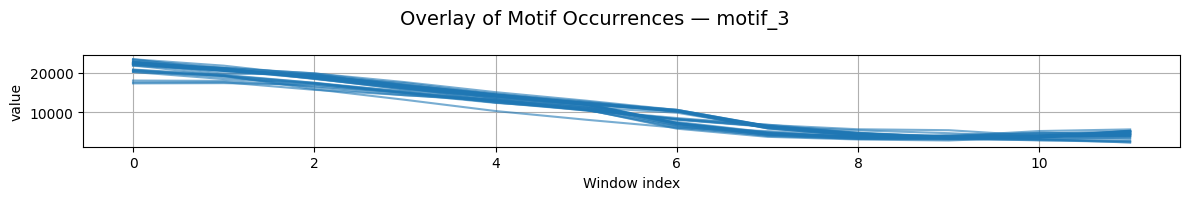

Window size : 0 days 00:50:00 ---


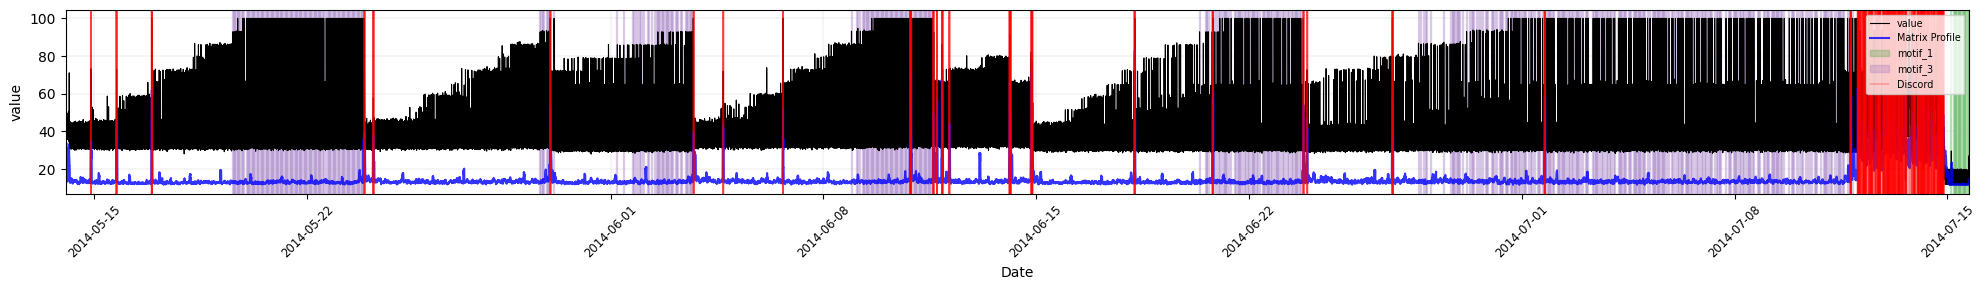

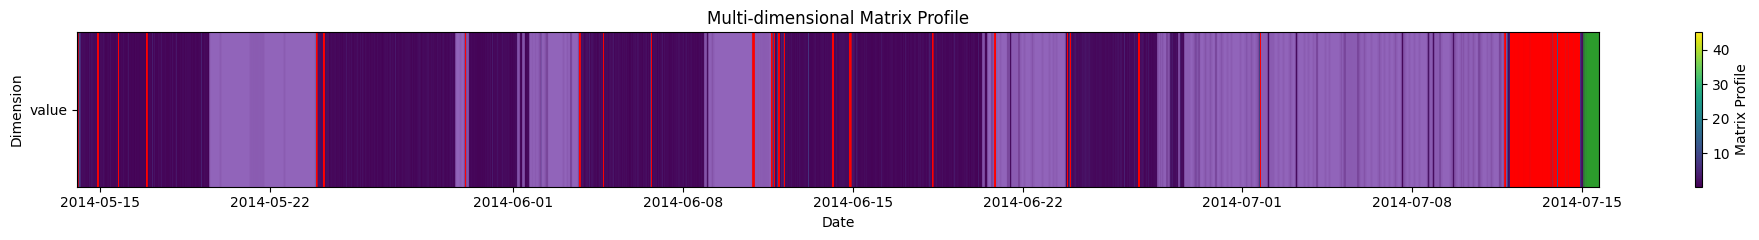

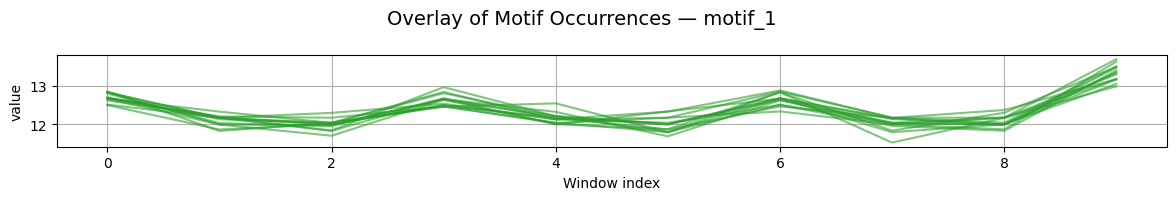

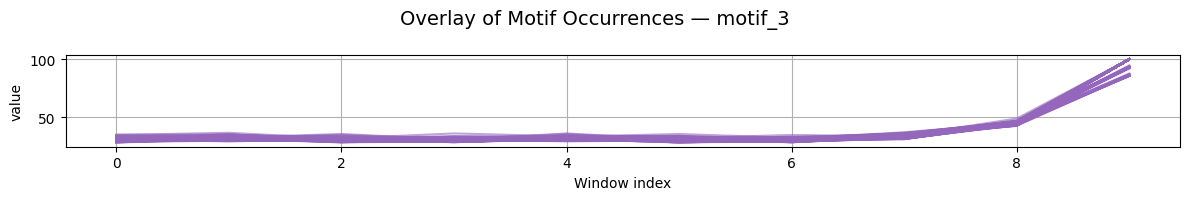

Window size : 0 days 23:00:00 ---


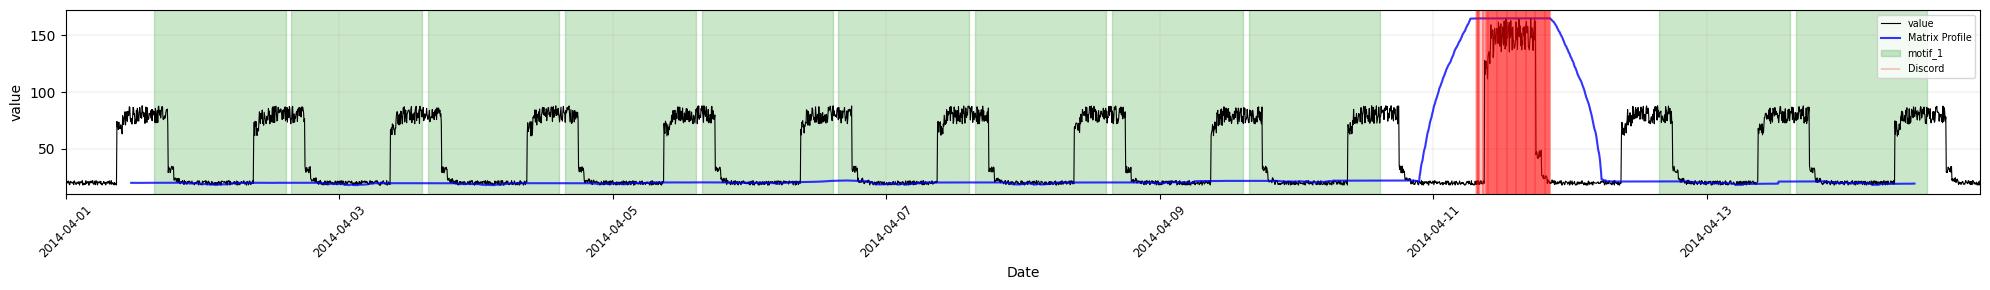

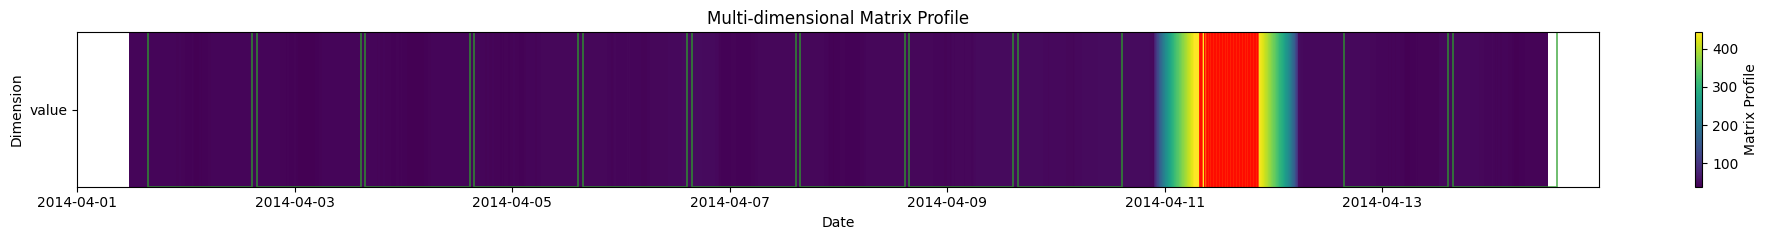

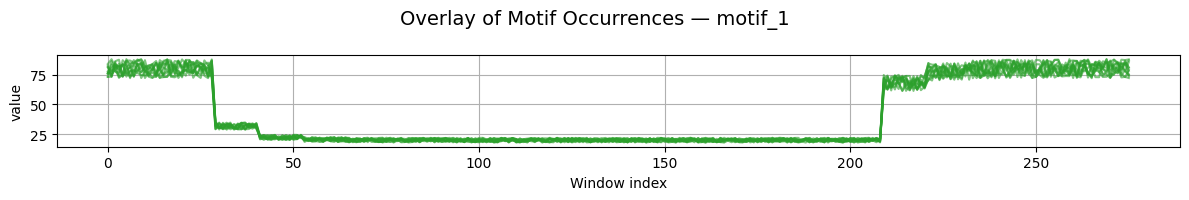

In [2]:
folder = '../../dataset'
pds = []

with os.scandir(folder) as entries:
    for entry in entries:
        if entry.is_file() and entry.name.endswith('csv'):
            pd = pandas.read_csv(folder+'/'+entry.name)
            _, _, _ = ampiimts(pd, top_k_cluster=4, motif=True)

